A regression problem aims to predict a continuous numeric value like price or probability. Unlike a classification problem, the model is trained to predict a class from a list of classes. A classic class problem is like predicting the class of a fruit image.


Reference:
* https://www.tensorflow.org/tutorials/keras/regression

In [0]:
!pip install -q tensorflow-gpu==2.0.0
!pip install -q git+https://github.com/tensorflow/docs  # use some functions from tensorflow docs 
!pip install -q seaborn  # for pairplot

In [0]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager model: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices('GPU') else "not"))

Tensorflow Version: 2.0.0
Eager model: True
GPU is available


# Dataset Preparation

Here you are going to use Auto MPG Dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

## Download and Import the Dataset

In [0]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", 
                                       "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 4us/step


In [0]:
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [0]:
col_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
             'Acceleration', 'Model Year', 'Origin']

In [0]:
raw_dataset = pd.read_csv(dataset_path, names=col_names, 
                          na_values="?", comment="\t", sep=" ", 
                          skipinitialspace=True)

In [0]:
dataset = raw_dataset.copy()
dataset.head(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Clean the Dataset

The dataset still contains several unknown values. To keep the dataset simple, we delete the row containing unknown values.

In [0]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

The column `Origin` is already a categorical value. We change the value to its categorical text.

In [0]:
dataset["Origin"] = dataset["Origin"].map(lambda x: {1: "USA", 2: "EU", 3: "Japan"}.get(x))

Use function `get_dummies()` to create one-hot encoding like columns.

In [0]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail(5)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,EU,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into sub-datasets

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect the Dataset

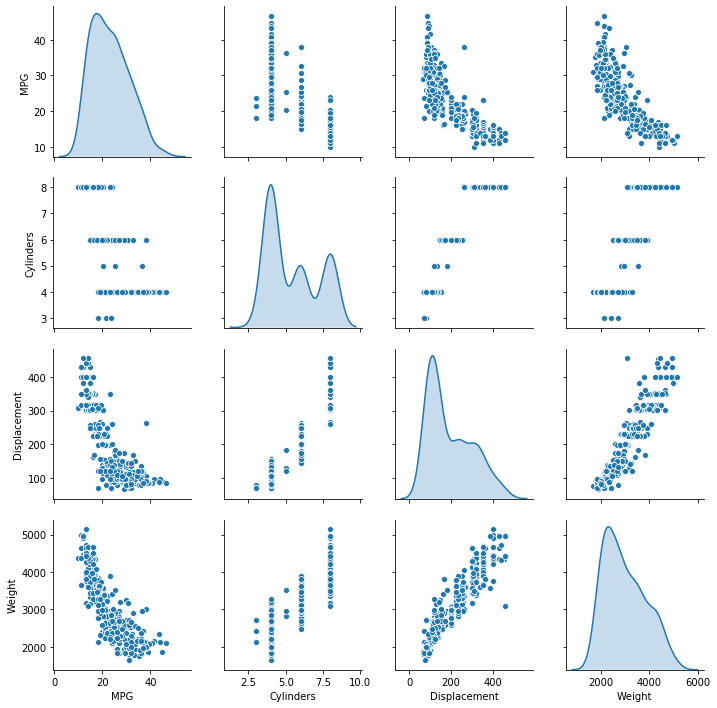

In [0]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
EU,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

Separate the feature which you are going to train a model to predict.

In [0]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [0]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Building the Model

In [0]:
def build_model(inputs):
  x = tf.keras.layers.Dense(units=64, activation='relu', 
                            input_shape=[len(train_dataset.keys())])(inputs)
  x = tf.keras.layers.Dense(units=64, activation='relu')(x)
  x = tf.keras.layers.Dense(units=1)(x)
  return x

In [0]:
inputs = tf.keras.Input(shape=[len(train_dataset.keys())])
outputs = build_model(inputs)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


## An Inference Example

In [0]:
example_batch = normed_train_data[:10]
example_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,EU,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,-0.465148,-0.495225,0.774676
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-0.465148,2.012852,-1.286751
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,2.143005,-0.495225,-1.286751
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,-0.465148,-0.495225,0.774676
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-0.465148,2.012852,-1.286751


In [0]:
example_result = model.predict(example_batch)
example_result

array([[-0.11728074],
       [ 0.11900982],
       [ 0.162511  ],
       [ 0.12951916],
       [ 0.35854924],
       [ 0.01670698],
       [ 0.4027663 ],
       [ 0.4421038 ],
       [-0.13462065],
       [ 0.21291679]], dtype=float32)

## Training the Model

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), 
              loss='mse', 
              metrics=["mae", "mse"])

In [0]:
EPOCHS = 1000

his = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                validation_split=0.2, verbose=0,
                callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:560.5284,  mae:22.4126,  mse:560.5284,  val_loss:549.2268,  val_mae:22.1249,  val_mse:549.2268,  
....................................................................................................
Epoch: 100, loss:6.0259,  mae:1.6846,  mse:6.0259,  val_loss:9.3346,  val_mae:2.2935,  val_mse:9.3346,  
....................................................................................................
Epoch: 200, loss:5.2588,  mae:1.5826,  mse:5.2588,  val_loss:9.1171,  val_mae:2.3280,  val_mse:9.1171,  
....................................................................................................
Epoch: 300, loss:4.6884,  mae:1.4774,  mse:4.6884,  val_loss:8.9965,  val_mae:2.1682,  val_mse:8.9965,  
....................................................................................................
Epoch: 400, loss:4.1754,  mae:1.3829,  mse:4.1754,  val_loss:8.7243,  val_mae:2.1900,  val_mse:8.7243,  
..............................................................

## View the training details via Pandas

In [0]:
hist = pd.DataFrame(his.history)
hist["epoch"] = his.epoch
hist.tail(5)

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.695503,1.040803,2.695503,9.315194,2.229961,9.315194,995
996,2.387631,0.945413,2.387631,9.242058,2.214490,9.242058,996
997,2.335660,0.963287,2.335660,9.609215,2.325791,9.609216,997
998,2.455732,0.960050,2.455733,9.875973,2.353245,9.875973,998
999,2.517316,0.951063,2.517316,9.176649,2.211093,9.176649,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

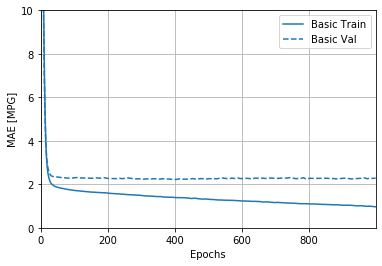

In [0]:
plotter.plot({'Basic': his}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

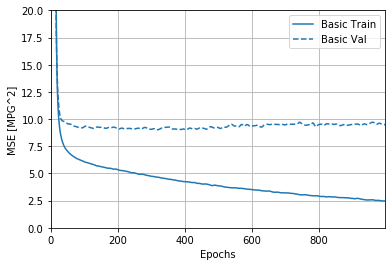

In [0]:
plotter.plot({'Basic': his}, metric="mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

## Introducing EarlyStopping

In [0]:
model = tf.keras.Model(inputs, outputs)

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3), 
              loss='mse', 
              metrics=["mae", "mse"])

In [0]:
early_his = model.fit(normed_train_data, train_labels, epochs=EPOCHS, 
                      validation_split=0.2, verbose=0, 
                      callbacks=[early_stopping, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.6850,  mae:1.0756,  mse:2.6850,  val_loss:9.9675,  val_mae:2.2819,  val_mse:9.9675,  
................................

## View Training details with the early stopping

Text(0, 0.5, 'MAE [MPG]')

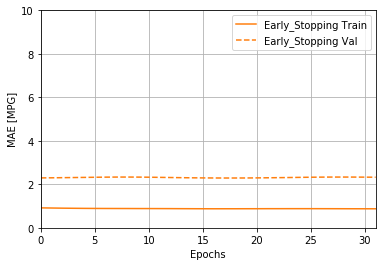

In [0]:
plotter.plot({'Early_Stopping': early_his}, metric='mae')
plt.ylim([0,10])
plt.ylabel("MAE [MPG]")

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

78/78 - 0s - loss: 7.4749 - mae: 2.0986 - mse: 7.4749


## Make Predictions

Finally you can use the model to predict the MPG value.

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

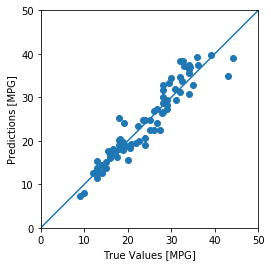

In [0]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

Let's take a look at the error distribution.

Text(0, 0.5, 'Count')

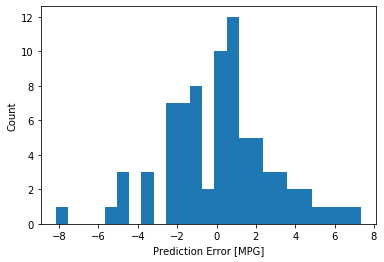

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
plt.ylabel('Count')